In [173]:
import pandas as pd 
import numpy as np 
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

### 1 Naive Bayesian Classifier

In [174]:
class GNiaveBayesClassifier:
    def __init__(self):
        self.means = {}
        self.variances = {}
        self.priors = {}

    
    def fit(self, X, y):
        self.classes = np.unique(y)
        
        for cls in self.classes:
            X_cls = X[y == cls]
            self.means[cls] = X_cls.mean(axis=0)
            self.variances[cls] = X_cls.var(axis=0)
            self.priors[cls] = X_cls.shape[0] / X.shape[0]

    
    def predict(self, X):
        predictions = []
        for x in X:
            posteriors = []
            for cls in self.classes:
                #could use log here and turn the products into addition for numerical stability
                prior = self.priors[cls]
                likelihood = np.prod(self._gaussian_proba(x, self.means[cls], self.variances[cls]))
                posteriors.append(prior*likelihood)
            predictions.append(self.classes[np.argmax(posteriors)])
        return np.array(predictions)

    
    def _gaussian_proba(self, X, mean, var):
        eps = 1e-6 
        coeff = 1 / np.sqrt(2 * np.pi * (var + eps))
        exponent = np.exp(-((X - mean)**2) / (2 * (var + eps)))
        return coeff * exponent
        

In [175]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    tp = np.sum((y_true == 'M') & (y_pred == 'M'))
    fp = np.sum((y_true == 'B') & (y_pred == 'M'))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall(y_true, y_pred):
    tp = np.sum((y_true == 'M') & (y_pred == 'M'))
    fn = np.sum((y_true == 'M') & (y_pred == 'B'))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def f1score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r) if (p + r) > 0 else 0

In [176]:
df = pd.read_csv('logistic (1).csv')

In [177]:
df.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [178]:
X = df.iloc[:,1:].values 
y = df.iloc[:,0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [179]:
pgnb = GNiaveBayesClassifier()
pgnb.fit(X_train, y_train)
y_pred_pgnb = pgnb.predict(X_test)

In [180]:
pgnb_accuracy = accuracy(y_test, y_pred_pgnb)
pgnb_precision = precision(y_test, y_pred_pgnb)
pgnb_recall = recall(y_test, y_pred_pgnb)
pgnb_f1 = f1score(y_test, y_pred_pgnb)

In [181]:
print(pgnb_accuracy)
print(pgnb_precision)
print(pgnb_recall)
print(pgnb_f1)

0.9649122807017544
0.975609756097561
0.9302325581395349
0.9523809523809524


In [182]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_sk = gnb.predict(X_test)

sk_accuracy = accuracy(y_test, y_pred_sk)
sk_precision = precision(y_test, y_pred_sk)
sk_recall = recall(y_test, y_pred_sk)
sk_f1 = f1score(y_test, y_pred_sk)

In [183]:
print(sk_accuracy)
print(sk_precision)
print(sk_recall)
print(sk_f1)

0.9649122807017544
0.975609756097561
0.9302325581395349
0.9523809523809524


### 2 MLP Regressor with PyTorch

In [205]:
class MLPRegressor(torch.nn.Module):
    def __init__(self, input_dim, hidden_layers, activation_fn):
        super(MLPRegressor, self).__init__()
        layers = []
        in_dim = input_dim
        for layer in hidden_layers:
            layers.append(nn.Linear(in_dim, layer))
            layers.append(activation_fn())
            in_dim = layer
        layers.append(nn.Linear(in_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [206]:
data = fetch_california_housing()
X, y = data.data, data.target  

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

In [207]:
input_dim = X_train.shape[1]
hidden_layers = [64, 32]
activation_fn = nn.ReLU
model = MLPRegressor(input_dim, hidden_layers, activation_fn)

In [208]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [209]:
epochs = 50
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss +=loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")       

Epoch 1/50, Train Loss: 1.1203, Val Loss: 0.5220
Epoch 2/50, Train Loss: 0.4566, Val Loss: 0.4409
Epoch 3/50, Train Loss: 0.4110, Val Loss: 0.4181
Epoch 4/50, Train Loss: 0.3972, Val Loss: 0.3965
Epoch 5/50, Train Loss: 0.3801, Val Loss: 0.3854
Epoch 6/50, Train Loss: 0.3629, Val Loss: 0.3731
Epoch 7/50, Train Loss: 0.3538, Val Loss: 0.3756
Epoch 8/50, Train Loss: 0.3495, Val Loss: 0.3687
Epoch 9/50, Train Loss: 0.3415, Val Loss: 0.3505
Epoch 10/50, Train Loss: 0.3314, Val Loss: 0.3502
Epoch 11/50, Train Loss: 0.3279, Val Loss: 0.3389
Epoch 12/50, Train Loss: 0.3190, Val Loss: 0.3409
Epoch 13/50, Train Loss: 0.3156, Val Loss: 0.3377
Epoch 14/50, Train Loss: 0.3091, Val Loss: 0.3279
Epoch 15/50, Train Loss: 0.3098, Val Loss: 0.3224
Epoch 16/50, Train Loss: 0.3005, Val Loss: 0.3518
Epoch 17/50, Train Loss: 0.2969, Val Loss: 0.3173
Epoch 18/50, Train Loss: 0.2939, Val Loss: 0.3155
Epoch 19/50, Train Loss: 0.2952, Val Loss: 0.3182
Epoch 20/50, Train Loss: 0.2904, Val Loss: 0.3156
Epoch 21/

In [210]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_mse = criterion(test_outputs, y_test_tensor)
    test_rmse = torch.sqrt(test_mse).item()
    test_mse.item()

print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Test MSE: 0.2566
Test RMSE: 0.5066


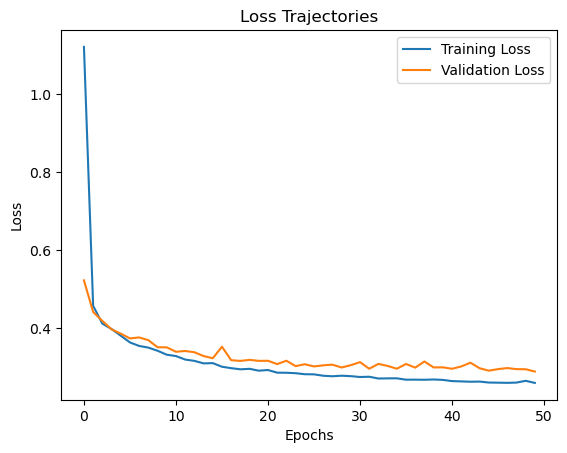

In [211]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trajectories')
plt.legend()
plt.show()